iter:50 training loss: 0.00019988464191555977, val loss: 0.00021851315977983177
iter:100 training loss: 3.7664605770260096e-05, val loss: 3.5693097743205726e-05
iter:150 training loss: 3.209382339264266e-05, val loss: 3.0139441150822677e-05
iter:200 training loss: 2.9455579351633787e-05, val loss: 2.8572299925144762e-05
iter:250 training loss: 2.8871343602077104e-05, val loss: 3.167589602526277e-05
iter:300 training loss: 2.8771424695150927e-05, val loss: 2.9360953703871928e-05
iter:350 training loss: 2.9950269890832715e-05, val loss: 2.7513557142810896e-05
iter:400 training loss: 2.753935223154258e-05, val loss: 2.9841456125723198e-05
iter:450 training loss: 2.8857020879513584e-05, val loss: 2.9784307116642594e-05
iter:500 training loss: 2.8708223908324726e-05, val loss: 2.7070136638940312e-05
iter:550 training loss: 3.069482045248151e-05, val loss: 2.8177564672660083e-05
iter:600 training loss: 2.799878711812198e-05, val loss: 2.7498714189277962e-05
iter:650 training loss: 2.84761190

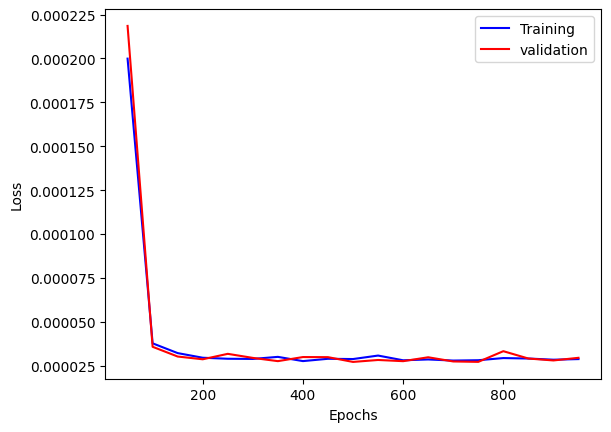

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px
from utils import *


def visualise_tensor(data):
    data = data.detach().numpy()

    colormap = 'RdBu_r'
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1)
    fig.show()
    fig.data = ()

weight_penalty_coefficient = 0.01

input_size = 30
hidden_layer_size= 5
output_size = input_size
learning_rate = 0.01
max_iters = 1000
dataset_size = 1024*32
sparsity = 0.01
batch_size = 32

decay_factor = 0.95
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.9**i for i in range(input_size)])


def sample_data():
    sparsity_vector = sparsity
    a, b = training_dataset.shape
    
    # Make sure sparsity_vector is a tensor and has the same device as training_dataset
    sparsity_vector = torch.tensor(sparsity_vector, device=training_dataset.device)
    
    # Reshape the sparsity vector to be broadcastable over the features dimension
    sparsity_vector = sparsity_vector.view(1, -1)
    
    # Create a sparsity matrix where each feature column has its corresponding sparsity
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = training_dataset * sparsity_mat
    return X, X

def sample_validation_data():
    sparsity_vector = sparsity
    a, b = validation_dataset.shape
    
    # Make sure sparsity_vector is a tensor and has the same device as training_dataset
    sparsity_vector = torch.tensor(sparsity_vector, device=training_dataset.device)
    
    # Reshape the sparsity vector to be broadcastable over the features dimension
    sparsity_vector = sparsity_vector.view(1, -1)
    
    # Create a sparsity matrix where each feature column has its corresponding sparsity
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = validation_dataset * sparsity_mat
    return X, X

        

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = SuperpositionModel(SuperPositionConfig(input_size, hidden_layer_size, imp_vector))

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = SuperpositionModel(SuperPositionConfig())
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X, Y = sample_data()
        logits, loss, _ = model(X, Y)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V,Y_V = sample_validation_data()
                _, val_loss, _ = model(X_V, Y_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        #loss+= get_l1_penalty()
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()
    plt.show()

In [8]:
encoder_w = model.encoder.weight.data
decoder_w = model.decoder.weight.data

# visualise_tensor(encoder_w.t())
# visualise_tensor(decoder_w.t())

visualise_tensor(decoder_w@encoder_w)
# visualise_tensor(model.decoder.bias.data.reshape(-1,1))

In [9]:
x,y = sample_data()

In [4]:
data = torch.tensor([])
original = torch.tensor([])
for i in range(10):
    x,y = sample_data()
    original = torch.cat((original, x))
    _,_,hidden = model(x,x)
    data = torch.cat((data,hidden))
    

torch.save(data, "data/hidden.pt")
torch.save(original, "data/original.pt")
PATH = "models/superpositon.pt"

torch.save(model.state_dict(), PATH)



In [39]:
LOAD_MODEL = False


In [13]:
x.shape

torch.Size([32768, 20])

In [19]:
a = torch.cat((a,x))

In [15]:
a

tensor([])

In [20]:
a.shape

torch.Size([65536, 20])